# Network Science (HS21)
## Assignment 6

### Ben     Murphy          16-714-925
### Florian Rüegsegger      14-714-737

#### The excercise was solved together in person



In [7]:
import os
import networkx as nx
import re
from networkx import read_graphml
from NEMtropy import UndirectedGraph, DirectedGraph
from NEMtropy.network_functions import build_adjacency_from_edgelist
import numpy as np
from typing import Dict
import matplotlib.pyplot as plt
from networkx import degree_pearson_correlation_coefficient

# A06.1

In [8]:
def fit_and_sample_cm(graph: nx.Graph,cm_class, model, name: str):
    adj_matrix = nx.to_numpy_array(graph)
    graph = cm_class(adj_matrix)
    graph.solve_tool(model=model)
    graph.ensemble_sampler(10,cpu_n=1, output_dir=f"samples/{graph.__class__.__name__}/{name}/")


def get_data(graph: nx.Graph, name: str, skip_sampling):
    if not skip_sampling:
        fit_and_sample_cm(graph, UndirectedGraph,"cm_exp",name)
        fit_and_sample_cm(graph, DirectedGraph,"dcm_exp", name)
    clusterings = []
    reciprocities = []
    for i in range(10):
        edgelist = np.loadtxt(f"samples/DirectedGraph/{name}/{i}.txt")
        net = nx.DiGraph()
        net.add_edges_from(edgelist)
        
        clusterings.append(nx.average_clustering(net))
        reciprocities.append(nx.reciprocity(net))

    return np.mean(clusterings), np.mean(reciprocities)


def plot_data(x,y,label):
    plt.plot(x, y, label=label)

def solve01(graphs: Dict,skip_sampling=False):
    clusters_og = []
    recip_og = []
    clusters_model = []
    recip_model = []
    
    keys = sorted([key for key in graphs.keys()])
    for key in keys:
        print(f"{key}")
        clusters_og.append(nx.average_clustering(graphs[key]))
        recip_og.append(nx.reciprocity(graphs[key]))

        data = get_data(graphs[key], key, skip_sampling)
        clusters_model.append(data[0])
        recip_model.append(data[1])
    
    plot_data(keys, clusters_og, "clusters_og")
    plot_data(keys, clusters_model, "clusters_model")
    plot_data(keys, recip_og, "recip_og")
    plot_data(keys, recip_model, "recip_model")
    plt.legend()
    plt.show()



In [9]:
data_paths = os.listdir('data/')
data = {}
regex = re.compile(r'\d+')
for data_path in data_paths:
    year = regex.findall(data_path)
    data[int(year[0])] = read_graphml('data/' + data_path)

1992


C:\Users\benmu\anaconda3\envs\networkscience\lib\site-packages\numba\core\utils.py:544: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",
C:\Users\benmu\anaconda3\envs\networkscience\lib\site-packages\NEMtropy\models_functions.py:461: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  step_fun = args[0]
C:\Users\benmu\anaconda3\envs\networkscience\lib\site-packages\NEMtropy\models_functions.py:462: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  arg_step_fun = args[1]
C:\Users\benmu\anaconda3\envs\networkscience\lib\site-packages\numba\core\utils.py:544: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",



solution error = 1.6869961427801172e-08


C:\Users\benmu\anaconda3\envs\networkscience\lib\site-packages\numba\core\utils.py:544: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",
C:\Users\benmu\anaconda3\envs\networkscience\lib\site-packages\NEMtropy\models_functions.py:3181: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  step_fun = args[0]
C:\Users\benmu\anaconda3\envs\networkscience\lib\site-packages\NEMtropy\models_functions.py:3182: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  arg_step_fun = args[1]
C:\Users\benmu\anaconda3\envs\networkscience\lib\site-packages\numba\core\utils.py:544: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",



solution error = 1.3640857332575251e-09
1993


C:\Users\benmu\anaconda3\envs\networkscience\lib\site-packages\numba\core\utils.py:544: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",



solution error = 2.32273464462196e-07

solution error = 5.982176531915684e-09
1994

solution error = 8.721084725493711e-07

solution error = 3.759666356017988e-09
1995

solution error = 1.8203451190856867e-07

solution error = 5.2841926390101435e-09
1996

solution error = 2.7372067279429757e-07

solution error = 1.8565522452718142e-09
1997

solution error = 1.08560965372817e-06

solution error = 3.358621825100272e-09
1998

solution error = 2.099386577469886e-06

solution error = 1.940179572557099e-09
1999

solution error = 4.017849164483778e-09

solution error = 3.5691414268512744e-09
2000

solution error = 6.103901739606954e-08

solution error = 4.081272209077724e-09
2001

solution error = 6.575695010724303e-08

solution error = 2.809525057045903e-09
2002

solution error = 7.940138857520651e-08

solution error = 2.3112747271625267e-09


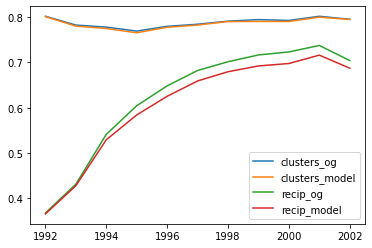

In [10]:
solve01(data,skip_sampling=False)

# A06.2

In [11]:
def fit_and_sample_crema(graph: nx.Graph,cm_class, adjaceny, name: str):
    adj_matrix = nx.to_numpy_array(graph)
    graph = cm_class(adj_matrix)
    graph.solve_tool(
        model="crema",
        method="newton",
        initial_guess="random",
        adjacency=adjaceny,
        method_adjacency="newton"
    )
    graph.ensemble_sampler(10,cpu_n=1, output_dir=f"samples/crema/{graph.__class__.__name__}/{name}/")


def get_data_weight(graph: nx.Graph, name: str, skip_sampling):
    if not skip_sampling:
        fit_and_sample_crema(graph, UndirectedGraph,"cm_exp",name)
        fit_and_sample_crema(graph, DirectedGraph,"dcm_exp", name)
    assortativities_directed = []
    assortativities_undirected = []

    for i in range(10):
        edgelist = np.loadtxt(f"samples/crema/DirectedGraph/{name}/{i}.txt")
        net = nx.DiGraph()
        net.add_weighted_edges_from(edgelist)
        assortativities_directed.append(degree_pearson_correlation_coefficient(net, weight="weight"))

    for i in range(10):
        edgelist = np.loadtxt(f"samples/crema/UndirectedGraph/{name}/{i}.txt")
        net = nx.Graph()
        net.add_weighted_edges_from(edgelist)
        assortativities_undirected.append(degree_pearson_correlation_coefficient(net, weight="weight"))
     
    

    return np.mean(assortativities_directed), np.mean(assortativities_undirected)

def plot_assortativities(graphs: nx.Graph,keys):
    in_in = []
    in_out = []
    out_in = []
    out_out = []
    in_in_model = []
    in_out_model = []
    out_in_model = []
    out_out_model = []
    for key in keys:
        print(f"Getting assortativity pairs for {key}")
        in_in.append(degree_pearson_correlation_coefficient(graphs[key], "in", "in", weight="weight"))
        in_out.append(degree_pearson_correlation_coefficient(graphs[key], "in", "out", weight="weight"))
        out_in.append(degree_pearson_correlation_coefficient(graphs[key], "out", "in", weight="weight"))
        out_out.append(degree_pearson_correlation_coefficient(graphs[key], "out", "out", weight="weight"))
        in_in_temp = []
        in_out_temp = []
        out_in_temp = []
        out_out_temp = []
        for i in range(10):
            edgelist = np.loadtxt(f"samples/crema/DirectedGraph/{key}/{i}.txt")
            net = nx.DiGraph()
            net.add_weighted_edges_from(edgelist)
            in_in_temp.append(degree_pearson_correlation_coefficient(net, "in", "in", weight="weight"))
            in_out_temp.append(degree_pearson_correlation_coefficient(net, "in", "out", weight="weight"))
            out_in_temp.append(degree_pearson_correlation_coefficient(net, "out", "in", weight="weight"))
            out_out_temp.append(degree_pearson_correlation_coefficient(net, "out", "out", weight="weight"))

        in_in_model.append(np.mean(in_in_temp))
        in_out_model.append(np.mean(in_out_temp))
        out_in_model.append(np.mean(out_in_temp))
        out_out_model.append(np.mean(out_out_temp))

    plot_data(keys,in_in,"in_in")
    plot_data(keys,in_out, "in_out")
    plot_data(keys,out_in, "out_in")
    plot_data(keys,out_out, "out_out")
    plot_data(keys,in_in_model,"in_in_model")
    plot_data(keys,in_out_model, "in_out_model")
    plot_data(keys,out_in_model, "out_in_model")
    plot_data(keys,out_out_model, "out_out_model")
    plt.xlabel("time")
    plt.ylabel("average assortativity")
    plt.title("Assortativity over time")
    plt.legend()
    plt.show()


def solve02(graphs: Dict,skip_sampling=False):
    assort_og = []
    assort_model_undirected = []
    assort_model_directed = []
    keys = sorted([key for key in graphs.keys()])
    for key in keys:
        print(f"{key}")
        assort_og.append(degree_pearson_correlation_coefficient(graphs[key], weight="weight"))
        data = get_data_weight(graphs[key], key, skip_sampling)
        assort_model_directed.append(data[0])
        assort_model_undirected.append(data[1])
    
    plot_data(keys, assort_og, "assort_og")
    plot_data(keys, assort_model_directed, "assort_model_directed")
    plot_data(keys, assort_model_undirected, "assort_model_undirected")
    plt.legend()
    plt.show()
    
    plot_assortativities(graphs,keys)




1992


C:\Users\benmu\anaconda3\envs\networkscience\lib\site-packages\numba\core\utils.py:544: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",
C:\Users\benmu\anaconda3\envs\networkscience\lib\site-packages\NEMtropy\models_functions.py:1554: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  step_fun = args[0]
C:\Users\benmu\anaconda3\envs\networkscience\lib\site-packages\NEMtropy\models_functions.py:1555: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  arg_step_fun = args[1]
C:\Users\benmu\anaconda3\envs\networkscience\lib\site-packages\numba\core\utils.py:544: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",



solution error = 224626101943.69757


C:\Users\benmu\anaconda3\envs\networkscience\lib\site-packages\numba\core\utils.py:544: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",
C:\Users\benmu\anaconda3\envs\networkscience\lib\site-packages\numba\core\utils.py:544: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",
C:\Users\benmu\anaconda3\envs\networkscience\lib\site-packages\NEMtropy\models_functions.py:4515: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  step_fun = args[0]
C:\Users\benmu\anaconda3\envs\networkscience\lib\site-packages\NEMtropy\models_functions.py:4516: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  arg_step_fun = args[1]
C:\Users\benmu\anaconda3\envs\networkscience\lib\site-packages\numba\core\utils.py:544: NumbaExperimentalFeature


solution error = 342169865838.4709
1993


C:\Users\benmu\anaconda3\envs\networkscience\lib\site-packages\numba\core\utils.py:544: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",



solution error = 319410002580.4287

solution error = 360307417251.9904
1994

solution error = 301401277341.7314

solution error = 406587686157.68
1995

solution error = 450650286904.36505

solution error = 451961251483.06396
1996

solution error = 466541197743.4445

solution error = 471562647005.1562
1997

solution error = 346765145395.2101

solution error = 505488110566.8678
1998

solution error = 392130031604.03534

solution error = 537414140266.7705
1999

solution error = 476461604048.09045

solution error = 560128896867.4703
2000

solution error = 2304980204746.8535

solution error = 6562899776094.2
2001

solution error = 1113041910365.7678

solution error = 575902916829.6947
2002

solution error = 467085962759.71674

solution error = 593149092526.9243


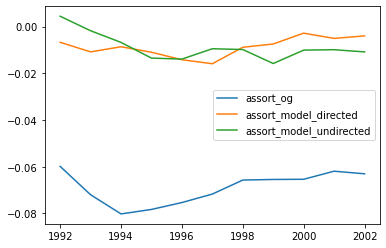

Getting assortativity pairs for 1992
Getting assortativity pairs for 1993
Getting assortativity pairs for 1994
Getting assortativity pairs for 1995
Getting assortativity pairs for 1996
Getting assortativity pairs for 1997
Getting assortativity pairs for 1998
Getting assortativity pairs for 1999
Getting assortativity pairs for 2000
Getting assortativity pairs for 2001
Getting assortativity pairs for 2002


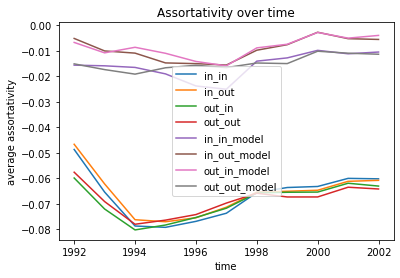

In [13]:
solve02(data, skip_sampling=False)

# A06.3

### Clustering
We see a high average clustering coefficient over all the years. It makes sense that local groups like trading with each other. Be it a similar culture or tradition. This reciprocity grew over the years as globalisation increases & trades go beyond local borders.
### Reciprocity
Reciprocity increases over time.

### Assortativity
The strength assortativity is slightly negativ for our original network. This would imply that there exists high degree nodes with lots of traffic from low degree nodes. However since it is only slightly negativ we cannot definitely conclude this.

### Comments on conclusions
The randomised models are able to recreate clustering coefficients and reciprocity levels of the original network. However it is unable to reproduce the assortativity of a real network on average. 
The undirected model can give us a misleading picture of the underlying relational patterns.
The weighted model gives us a better overview of how the traffic/network intensity is distributed. 